In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle
nltk.download('punkt')
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('kampus_merdeka1.json').read()
intents = json.loads(data_file)


In [4]:
for intent in intents['intents']:
    for pattern in intent['patterns']:
        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))
        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])


In [5]:
nltk.download('wordnet')
# lemmaztize and lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)

[nltk_data] Downloading package wordnet to /root/nltk_data...


108 documents
29 classes ['Daftar_Pemilih_Tetap(DPT)', 'SmartKonstituen', 'apa_itu_pemilu', 'cara_memastikan_pemilu', 'cara_memilih_calon_pemilu', 'cara_mendaftar_sebagai_pemilih', 'dilaksanakan_pemilu', 'goodbye', 'greeting', 'hasil_pemilu', 'jumlah_pemilih', 'lokasi_tps', 'partai_baru', 'pelaksanaan_pemilu', 'pelangaran_pemilu', 'pemilihan_presiden', 'pencalonan_pemilu', 'pencipta_SmartKonstituen', 'pengertian_pemilihan_presiden', 'pengertian_pileg', 'penjelasan_dpt', 'pentingnya_pemilu', 'peran_kpu', 'perbedaaan_suara_sah_dan_tidak_sah', 'perbedaan_pemilu_legislatif_dan_pemilu_presiden?', 'persyaratan_pemilu', 'siapa_yang_berhak_memilih', 'terimakasih', 'tujuan_pemilu']
149 unique lemmatized words ['(', ')', ',', '17', '2024', 'ada', 'adalah', 'adil', 'afternoon', 'akan', 'antara', 'apa', 'apakah', 'atau', 'bagaimana', 'bagi', 'bai', 'banyak', 'baru', 'bedanya', 'berapa', 'berhak', 'berjalan', 'bisa', 'bro', 'buat', 'bye', 'byee', 'calon', 'cara', 'cek', 'dadah', 'daerah', 'daftar',

In [6]:
pickle.dump(words,open('texts.pkl','wb'))
pickle.dump(classes,open('labels.pkl','wb'))

In [7]:
pickle.dump(words,open('texts.pkl','wb'))
pickle.dump(classes,open('labels.pkl','wb'))
# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    
    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

Training data created


<ipython-input-7-6e44f9343507>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


In [8]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

In [9]:
# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
#fitting and saving the model 
hist = model.fit(np.array(train_x), np.array(train_y), epochs=400, batch_size=5, verbose=1)
model.save('model.h5', hist)
print("model created")

Epoch 1/400
22/22 [==============================] - 4s 3ms/step - loss: 3.3775 - accuracy: 0.0278
Epoch 2/400
22/22 [==============================] - 0s 3ms/step - loss: 3.2220 - accuracy: 0.1296
Epoch 3/400
22/22 [==============================] - 0s 3ms/step - loss: 3.0567 - accuracy: 0.2315
Epoch 4/400
22/22 [==============================] - 0s 3ms/step - loss: 2.8979 - accuracy: 0.2593
Epoch 5/400
22/22 [==============================] - 0s 3ms/step - loss: 2.6675 - accuracy: 0.3056
Epoch 6/400
22/22 [==============================] - 0s 3ms/step - loss: 2.4799 - accuracy: 0.3056
Epoch 7/400
22/22 [==============================] - 0s 3ms/step - loss: 2.2153 - accuracy: 0.4167
Epoch 8/400
22/22 [==============================] - 0s 3ms/step - loss: 2.1017 - accuracy: 0.4259
Epoch 9/400
22/22 [==============================] - 0s 3ms/step - loss: 1.8678 - accuracy: 0.4722
Epoch 10/400
22/22 [==============================] - 0s 3ms/step - loss: 1.7456 - accuracy: 0.5093
Epoch 11/

In [23]:
hist.history.keys()

dict_keys(['loss', 'accuracy'])

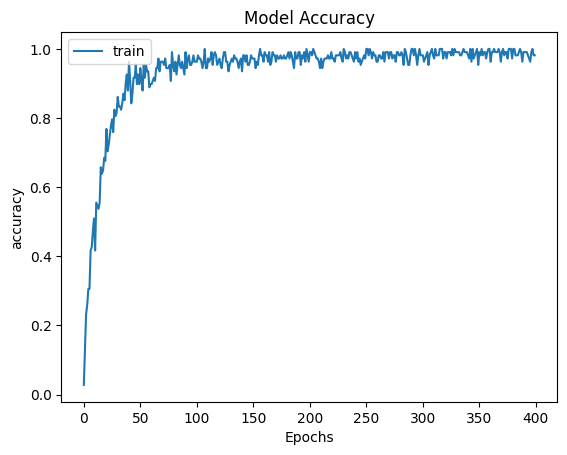

In [24]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(['train'], loc='upper left')
plt.show()

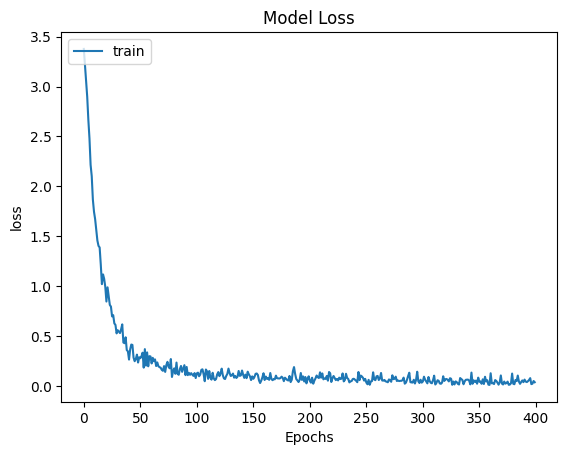

In [25]:
plt.plot(hist.history['loss'])
plt.title('Model Loss')
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(['train'], loc='upper left')
plt.show()

In [28]:
model.evaluate(train_x,train_y,batch_size=400)

1/1 [==============================] - 0s 161ms/step - loss: 5.8565e-06 - accuracy: 1.0000


[5.856517873326084e-06, 1.0]